This file contains the work to generate core users and feeding it to IDCF codebase for ML-100k dataset.
- greater than 30 interactions are taken into.
- Less than 30 interations are taken into test set
- some x% of coreusers are choosen as training set
- coreusers are calculated using CUR decomposition and R matrix is taken as coreuser.
- always the results are tested on test set.

In [1]:
from fileinput import filename
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.sparse.linalg import svds
import random 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import scipy.stats as ss
import pickle

In [8]:
def ReadData(threshold=30):
    # uncomment this line for movielens dataset
    ml1m_dir = 'data/u.data'
    ml1m_rating = pd.read_csv(ml1m_dir, delim_whitespace=True, header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')
    # use the below 2 lines for pinterest dataset.
    # ml1m_dir = 'data/pin-interest-main.txt'
    # ml1m_rating = pd.read_csv(ml1m_dir, delim_whitespace=True, header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')

    unique_uid = np.unique(np.array(ml1m_rating['uid'].tolist()))
    unique_mid = np.unique(np.array(ml1m_rating['mid'].tolist()))
    uid_dict = dict([(y,x) for x,y in enumerate(unique_uid)])
    mid_dict = dict([(y,x) for x,y in enumerate(unique_mid)])
    print('DICTIONARY PREPARED:')

    # init user item dictionary:
    
    uid_list = ml1m_rating['uid'].tolist()
    uid_list_len = len(uid_list)
    mid_list = ml1m_rating['mid'].tolist()
    mid_list_len = len(mid_list)
    rating_list = ml1m_rating['rating'].tolist()
    user_item_dict = {x:set() for x in range(len(unique_uid))}
    item_user_dict = {x:set() for x in range(len(unique_mid))}
    for i in range(uid_list_len):
        uid_list[i] = uid_dict[uid_list[i]]
        mid_list[i] = mid_dict[mid_list[i]]
        # rating_list[i] = 1 # comment this line if you want to activate explicit ratings
        user_item_dict[uid_list[i]].add(mid_list[i])
        item_user_dict[mid_list[i]].add(uid_list[i])
    tmp_df = pd.DataFrame({"uid":uid_list, "mid":mid_list, "ratings":rating_list})
    v = tmp_df.uid.value_counts()
    df = tmp_df[tmp_df.uid.isin(v.index[v.gt(threshold)])]
### code to store less than 30 interactions:
    df_less_30 = tmp_df[tmp_df.uid.isin(v.index[v.le(threshold)])]
    return df, df_less_30, len(np.unique(mid_list)), len(unique_uid)

In [10]:
THRESHOLD = 30 #split the users into test and train by threshold number of interactions. if greater than threshold then all interactions of that user goes into train set.
df_gt_30, df_le_30, unique_mids, unique_uids = ReadData(THRESHOLD)
print("GREATER THAN 30:\n", df_gt_30)
print("LESS THAN 30: \n", df_le_30)
print("GREATER THAN THRESHOLD: ", len(df_gt_30))
print("LESS THAN THRESHOLD: " ,len(df_le_30))
print("UNIQUE MIDS: ", unique_mids)
print("UNIQUE UIDS: ", unique_uids)

<bound method NDFrame.head of        uid   mid  rating  timestamp
0      196   242       3  881250949
1      186   302       3  891717742
2       22   377       1  878887116
3      244    51       2  880606923
4      166   346       1  886397596
...    ...   ...     ...        ...
99995  880   476       3  880175444
99996  716   204       5  879795543
99997  276  1090       1  874795795
99998   13   225       2  882399156
99999   12   203       3  879959583

[100000 rows x 4 columns]>
DICTIONARY PREPARED:
GREATER THAN 30:
        uid   mid  ratings
0      195   241        3
1      185   301        3
2       21   376        1
3      243    50        2
5      297   473        4
...    ...   ...      ...
99995  879   475        3
99996  715   203        5
99997  275  1089        1
99998   12   224        2
99999   11   202        3

[94849 rows x 3 columns]
LESS THAN 30: 
        uid   mid  ratings
4      165   345        1
30      49   245        3
32     224   192        4
37     277   

In [11]:
support_test_df = df_gt_30.groupby("uid").tail(1)
# print(len(df_gt_30['uid']))
support_train_df = df_gt_30.drop(df_gt_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_gt_30)== len(support_test_df) + len(support_train_df))
# print(len(test_df))
# print(len(train_df))
query_test_df = df_le_30.groupby("uid").tail(1)
query_train_df = df_le_30.drop(df_le_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_le_30)== len(query_test_df) + len(query_train_df))
dic_support_train_df_uid_mapping = dict([(y,x) for x,y in enumerate(np.unique(support_train_df['uid']))])
dic_support_train_df_uid_rmapping = dict([(x,y) for x,y in enumerate(np.unique(support_train_df['uid']))])
### no need for mid mapping

uid_of_train_df = support_train_df['uid'].tolist()
for i in range(len(uid_of_train_df)):
    uid_of_train_df[i] = dic_support_train_df_uid_mapping[uid_of_train_df[i]]
# for index, row in train_df.iterrows():
#     train_df['uid'][index] = dic_train_df_uid_mapping[train_df['uid'][index]]
core_user_ko_input_train_df = pd.DataFrame({'uid':uid_of_train_df, 'mid':support_train_df['mid'], 'ratings':support_train_df['ratings']})
print("NUMBER OF USERS IN SUPPORT TEST:", len(np.unique(support_test_df['uid'])))
print("NUMBER OF USERS IN SUPPORT TRAIN", len(np.unique(support_train_df['uid'])))
print("NUMBER OF USERS IN QUERY TEST:", len(np.unique(query_test_df['uid'])))
print("NUMBER OF USERS IN QUERY TRAIN", len(np.unique(query_train_df['uid'])))

NUMBER OF USERS IN SUPPORT TEST: 730
NUMBER OF USERS IN SUPPORT TRAIN 730
NUMBER OF USERS IN QUERY TEST: 213
NUMBER OF USERS IN QUERY TRAIN 213


In [12]:
train_ui_dic = {}    
for user in range(unique_uids):
    train_ui_dic[user] = []
for index,row in support_train_df.iterrows():
        train_ui_dic[row['uid']].append(row['mid'])

- utility functions for CUR coreusers.

In [13]:
MAX_MID = 27277 + 1
def select_cols(mat, k, dup=False):
    # prob 1d array of probabilities of all columns
    prob = mat.T.dot(mat)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis = 0)
    prob = prob/denom

    C = np.zeros((mat.shape[0], k))
    ind_cols = np.arange(0, prob.size)
    c_ind = []
    i = 0
    while(i < k):
        rand_sel = np.random.choice(ind_cols, 1, p=prob)
        if rand_sel in c_ind:
            continue
        c_ind.append(rand_sel[0])
        C[:, i] = mat[:, rand_sel[0]]
        i += 1
        # C[:, i] = C[:, i]/np.sqrt(k*prob[rand_sel[0]])

    return C, c_ind

def select_rows(mat, k, dup=False):

    prob = mat.dot(mat.T)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis=0)
    prob = prob/denom
    print(prob)
    r = np.zeros((k, mat.shape[1]))
    ind_rows = np.arange(0, prob.size)
    r_ind = []
    i = 0
    while(i < k):
        # print(ind_rows)
        rand_sel = np.random.choice(ind_rows, 1, p=prob)
        if rand_sel in r_ind:
            continue
        r_ind.append(rand_sel[0])
        r[i, :] = mat[rand_sel[0], :]
        i += 1
        # r[i, :] = r[i, :]/np.sqrt(k*prob[rand_sel[0]])
    r_ind = np.array(r_ind)
    return r, r_ind

# def matIntersection(mat, c_ind, r_ind):
    
#     W = np.zeros((len(r_ind), len(c_ind)))
#     for i in range(len(r_ind)):
#         W[i] = mat[r_ind[i], c_ind]
    
#     return W

# def pseudoInverse(W):
#     # U = WP (W+)

#     # W = X.Z.YT
#     X, Z, YT = np.linalg.svd(W)
    
#     # W+ = Y.Z+.XT
#     XT = X.T
#     Y = YT.T
#     # Z+ = reciprocal(Z)
#     ZP = np.reciprocal(Z)
#     ZP = sp.spdiags(ZP, 0, ZP.size, ZP.size)
#     ZP = ZP@ZP
    
#     # W+ = Y.Z+.XT
#     WP = Y@ZP
#     WP = WP@XT

#     return WP

In [ ]:
def ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    df = pd.DataFrame(userItemMatrix)
    cosineSimilarity = cosine_similarity(df)
    print("SHAPE OF COSINE MATIX:\n ", cosineSimilarity.shape)

    listToStoreTopFiftyOfEveryUser = []
    for i in range(0, cosineSimilarity.shape[0]):
        idx = np.argpartition(cosineSimilarity[i], -50)[-50:]
        listToStoreTopFiftyOfEveryUser.append(idx)
    # print("Top fifty list: \n", listToStoreTopFiftyOfEveryUser)
    # listToStoreTopFiftyOfEveryUser = np.array(listToStoreTopFiftyOfEveryUser)
    flatten = np.concatenate(listToStoreTopFiftyOfEveryUser)
    listToStoreTopFiftyOfEveryUser = flatten.ravel()

    # print("List of top 50", listToStoreTopFiftyOfEveryUser)
    df = pd.DataFrame(listToStoreTopFiftyOfEveryUser)
    allUserList = df.value_counts().index.tolist()
    # print("ALL USERS LIST", allUserList)
    allUserList = list(sum(allUserList,()))
    # print("ALL USERS LIST", allUserList)
    twentyPercentUserList = allUserList[:int(len(allUserList)*0.2)]
    # print("TWENTY PERCENT USER:", len(twentyPercentUserList))
    # print("TWENTY PERCENT USER:", (twentyPercentUserList))
    coreusers = dataframe.iloc[np.where(dataframe.uid.isin(twentyPercentUserList))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return coreusers

In [14]:
def CUR_ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    mat = userItemMatrix
    print("MAT:", mat)
    print(mat.shape)
    C, c_ind = select_cols(mat, int(u_len * 0.10)) ## getting 20% core users
    r, r_ind= select_rows(mat, int(u_len * 0.10))
    print("r", r)
    print("r_ind len", len(r_ind))

    cur_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(r_ind))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return cur_coreusers

In [15]:
# core_users = CUR_ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
core_users = ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
support_user_list = np.unique(core_users['uid'])
print("CORE USERS:" ,core_users)
print("NUMBER OF CORE USERS:", len(support_user_list))

USER LEN: 730
MOVIE LEN: 1682
USER ITEM MATRIX: 
 [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
MAT: [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
(730, 1682)
[0.0030804  0.0007046  0.00036897 0.00135184 0.00233006 0.00525776
 0.00072165 0.00256493 0.00179832 0.00077901 0.00571432 0.00133324
 0.00080304 0.00213085 0.00338115 0.00039455 0.00122937 0.00132161
 0.00164639 0.0010007  0.00100303 0.00077824 0.00089141 0.00035811
 0.00049841 0.00044105 0.00036819 0.00062786 0.00151539 0.00024339
 0.000586   0.0021231  0.00253393 0.00166267 0.00050151 0.00077669
 0.00144873 0.00080614 0.00074491 0.00204171 0.00107977 0.00191924
 0.0049136  0.00273701 0.00217039 0.00076971 0.00213395 0.00099063
 0.00037904 0.00030695 0.00079452 0.00127975 0.00044725 0.00165182
 0.00076584 0.0004

In [33]:
print(len(support_user_list))
len(np.unique(uid_of_train_df))
# print()

523


5231

In [16]:
core_users_index_list = core_users.index.to_list()
# non_core_user_index = (train_df.index.difference(core_users.index))
# non_core_user_index = non_core_user_index.tolist()

core_users_df = support_train_df.loc[core_users_index_list]
# non_core_user_df = train_df.loc[non_core_user_index]
# print("NON CORE USERS:" ,non_core_user_df)
print("CORE USERS:" ,core_users)

CORE USERS:        uid   mid  ratings
0      144   241        3
12     148   221        5
19     173  1183        2
31     223    97        4
40       7    15        4
...    ...   ...      ...
99830  375   312        3
99831  511   215        4
99863  549   863        4
99925  723   250        4
99968  723   286        4

[14039 rows x 3 columns]


In [17]:
# print("TEST DF CONTAINS TEST FOR CORE AND NON CORE ENTITIES:\n" ,test_df)
# print(core_users['uid'])
unique_uids_in_support_trian = np.unique(np.array(core_users_df['uid']))
unique_uids_in_query_trian = np.unique(query_train_df['uid'])
print(len(unique_uids_in_support_trian))
support_test_df = support_test_df.loc[support_test_df['uid'].isin(unique_uids_in_support_trian)]
print("SUPPORT TEST DF:" ,support_test_df)
query_test_df = query_test_df
print("QUERY TEST DF:\n", query_test_df)

73
SUPPORT TEST DF:        uid  mid  ratings
87863  195  109        1
91815  262  140        5
92883  135  257        5
92968  339  377        5
95725  599  801        2
...    ...  ...      ...
99973  820  150        4
99977  486  290        3
99994  377   77        3
99995  879  475        3
99998   12  224        2

[73 rows x 3 columns]
QUERY TEST DF:
        uid   mid  ratings
54279  219   339        4
63737  211   316        5
68894  308   878        4
70158  417  1312        2
73085  126   689        1
...    ...   ...      ...
99886  484   751        3
99902  440   281        4
99930  894    99        4
99936  724   275        4
99946  562   565        4

[213 rows x 3 columns]


In [18]:
support_train = []
for index,row in core_users_df.iterrows():
    support_train.append([row['uid'], row['mid'], row['ratings']])
query_train = []
for index, row in query_train_df.iterrows():
    query_train.append([row['uid'], row['mid'], row['ratings']])
support_test = []
for index, row in support_test_df.iterrows():
    support_test.append([row['uid'], row['mid'], row['ratings']])
query_test = []
for index, row in query_test_df.iterrows():
    query_test.append([row['uid'], row['mid'], row['ratings']])
user_his_dic = {}
for u in train_ui_dic.keys():
    user_his_dic[u] = train_ui_dic[u]
user_supp_list = np.unique(core_users_df['uid']).tolist()

In [19]:
import pickle
with open("ML100K_cur_10_support_as_core.pkl", "wb") as f:
    pickle.dump(support_train, f)
    pickle.dump(query_train, f)
    pickle.dump(support_test, f)
    pickle.dump(query_test, f)
    pickle.dump(user_supp_list, f)
    pickle.dump(user_his_dic, f)

- 10% pin cur coreusers into IDCF

In [20]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 14039/4938
test set size: support/query 73/213
Epoch 0 Step 14: Train 12.3978 Reg: 0.4964
Test: 12.7262 MAE: 3.3791 RMSE: 3.5674
Val: 12.7031 MAE: 3.3702 RMSE: 3.5641
Epoch 1 Step 28: Train 10.6703 Reg: 0.3973
Test: 10.2888 MAE: 2.9994 RMSE: 3.2076
Val: 10.2432 MAE: 2.9839 RMSE: 3.2005
Epoch 2 Step 42: Train 7.7408 Reg: 0.3334
Test: 6.1180 MAE: 2.2373 RMSE: 2.4735
Val: 6.0393 MAE: 2.2188 RMSE: 2.4575
Epoch 3 Step 56: Train 3.7693 Reg: 0.3059
Test: 2.3146 MAE: 1.3249 RMSE: 1.5214
Val: 2.2933 MAE: 1.3182 RMSE: 1.5144
Epoch 4 Step 70: Train 1.5114 Reg: 0.2995
Test: 1.2311 MAE: 0.9418 RMSE: 1.1096
Val: 1.2683 MAE: 0.9608 RMSE: 1.1262
Epoch 5 Step 84: Train 1.0973 Reg: 0.2925
Test: 1.1142 MAE: 0.8832 RMSE: 1.0556
Val: 1.1542 MAE: 0.8954 RMSE: 1.0743
Epoch 6 Step 98: Train 1.0277 Reg: 0.2900
Test: 1.0658 MAE: 0.8584 RMSE: 1.0324
Val: 1.0923 MAE: 0.8658 RMSE: 1.0451
Epoch 7 Ste

- 20% CUR coueusers to IDCF

In [21]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 28113/4938
test set size: support/query 146/213
Epoch 0 Step 27: Train 11.8516 Reg: 0.4544
Test: 10.1840 MAE: 2.9919 RMSE: 3.1912
Val: 9.8517 MAE: 2.9453 RMSE: 3.1387
Epoch 1 Step 54: Train 5.9453 Reg: 0.3438
Test: 2.2150 MAE: 1.2813 RMSE: 1.4883
Val: 2.0449 MAE: 1.2261 RMSE: 1.4300
Epoch 2 Step 81: Train 1.3096 Reg: 0.3353
Test: 1.1500 MAE: 0.9070 RMSE: 1.0724
Val: 1.1098 MAE: 0.8699 RMSE: 1.0535
Epoch 3 Step 108: Train 1.0737 Reg: 0.3237
Test: 1.0898 MAE: 0.8863 RMSE: 1.0440
Val: 1.0361 MAE: 0.8436 RMSE: 1.0179
Epoch 4 Step 135: Train 0.9819 Reg: 0.3101
Test: 1.0423 MAE: 0.8598 RMSE: 1.0209
Val: 0.9728 MAE: 0.8162 RMSE: 0.9863
Epoch 5 Step 162: Train 0.9120 Reg: 0.3050
Test: 1.0153 MAE: 0.8245 RMSE: 1.0076
Val: 0.9274 MAE: 0.7873 RMSE: 0.9630
Epoch 6 Step 189: Train 0.8623 Reg: 0.3028
Test: 0.9948 MAE: 0.8002 RMSE: 0.9974
Val: 0.9028 MAE: 0.7646 RMSE: 0.9501
Epoch 7 St

- 40% CUR core user as input to IDCF

In [22]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 54098/4938
test set size: support/query 292/213
Epoch 0 Step 51: Train 9.2581 Reg: 0.4232
Test: 2.3255 MAE: 1.3308 RMSE: 1.5250
Val: 2.1361 MAE: 1.2580 RMSE: 1.4615
Epoch 1 Step 102: Train 1.1975 Reg: 0.3854
Test: 1.0648 MAE: 0.8606 RMSE: 1.0319
Val: 1.0284 MAE: 0.8364 RMSE: 1.0141
Epoch 2 Step 153: Train 0.9472 Reg: 0.3603
Test: 0.9743 MAE: 0.7931 RMSE: 0.9871
Val: 0.9354 MAE: 0.7747 RMSE: 0.9672
Epoch 3 Step 204: Train 0.8730 Reg: 0.3485
Test: 0.9331 MAE: 0.7668 RMSE: 0.9660
Val: 0.9028 MAE: 0.7526 RMSE: 0.9502
Epoch 4 Step 255: Train 0.8457 Reg: 0.3388
Test: 0.9246 MAE: 0.7617 RMSE: 0.9616
Val: 0.8867 MAE: 0.7450 RMSE: 0.9417
Epoch 5 Step 306: Train 0.8326 Reg: 0.3300
Test: 0.9147 MAE: 0.7567 RMSE: 0.9564
Val: 0.8801 MAE: 0.7424 RMSE: 0.9381
Epoch 6 Step 357: Train 0.8252 Reg: 0.3229
Test: 0.9110 MAE: 0.7535 RMSE: 0.9544
Val: 0.8772 MAE: 0.7404 RMSE: 0.9366
Epoch 7 St

- 60% CUR coreusers input to IDCF

In [23]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 71238/4938
test set size: support/query 438/213
Epoch 0 Step 67: Train 7.5163 Reg: 0.4335
Test: 1.2103 MAE: 0.9155 RMSE: 1.1001
Val: 1.1605 MAE: 0.8884 RMSE: 1.0772
Epoch 1 Step 134: Train 1.0571 Reg: 0.4197
Test: 1.0416 MAE: 0.8259 RMSE: 1.0206
Val: 0.9722 MAE: 0.7989 RMSE: 0.9860
Epoch 2 Step 201: Train 0.9068 Reg: 0.3951
Test: 0.9691 MAE: 0.7668 RMSE: 0.9844
Val: 0.9059 MAE: 0.7478 RMSE: 0.9518
Epoch 3 Step 268: Train 0.8621 Reg: 0.3814
Test: 0.9531 MAE: 0.7622 RMSE: 0.9763
Val: 0.8868 MAE: 0.7391 RMSE: 0.9417
Epoch 4 Step 335: Train 0.8479 Reg: 0.3683
Test: 0.9422 MAE: 0.7586 RMSE: 0.9707
Val: 0.8817 MAE: 0.7373 RMSE: 0.9390
Epoch 5 Step 402: Train 0.8408 Reg: 0.3573
Test: 0.9490 MAE: 0.7616 RMSE: 0.9742
Val: 0.8764 MAE: 0.7347 RMSE: 0.9362
Epoch 6 Step 469: Train 0.8366 Reg: 0.3476
Test: 0.9453 MAE: 0.7599 RMSE: 0.9723
Val: 0.8756 MAE: 0.7348 RMSE: 0.9357
Epoch 7 St

- 80% cur into IDCF

In [24]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 84997/4938
test set size: support/query 584/213
Epoch 0 Step 79: Train 6.6028 Reg: 0.4592
Test: 1.1456 MAE: 0.8695 RMSE: 1.0703
Val: 1.1703 MAE: 0.8688 RMSE: 1.0818
Epoch 1 Step 158: Train 1.0108 Reg: 0.4572
Test: 0.9544 MAE: 0.7821 RMSE: 0.9769
Val: 0.9422 MAE: 0.7755 RMSE: 0.9707
Epoch 2 Step 237: Train 0.8862 Reg: 0.4287
Test: 0.9027 MAE: 0.7476 RMSE: 0.9501
Val: 0.8970 MAE: 0.7449 RMSE: 0.9471
Epoch 3 Step 316: Train 0.8556 Reg: 0.4094
Test: 0.8874 MAE: 0.7436 RMSE: 0.9420
Val: 0.8798 MAE: 0.7384 RMSE: 0.9380
Epoch 4 Step 395: Train 0.8451 Reg: 0.3925
Test: 0.8758 MAE: 0.7390 RMSE: 0.9359
Val: 0.8752 MAE: 0.7361 RMSE: 0.9355
Epoch 5 Step 474: Train 0.8399 Reg: 0.3775
Test: 0.8745 MAE: 0.7379 RMSE: 0.9352
Val: 0.8731 MAE: 0.7347 RMSE: 0.9344
Epoch 6 Step 553: Train 0.8369 Reg: 0.3643
Test: 0.8760 MAE: 0.7383 RMSE: 0.9360
Val: 0.8677 MAE: 0.7334 RMSE: 0.9315
Epoch 7 St

- 100% cur to IDCF

In [25]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 94119/4938
test set size: support/query 730/213
Epoch 0 Step 88: Train 6.3013 Reg: 0.4731
Test: 1.1631 MAE: 0.8794 RMSE: 1.0785
Val: 1.1481 MAE: 0.8679 RMSE: 1.0715
Epoch 1 Step 176: Train 0.9799 Reg: 0.4807
Test: 0.9898 MAE: 0.7880 RMSE: 0.9949
Val: 0.9420 MAE: 0.7761 RMSE: 0.9706
Epoch 2 Step 264: Train 0.8817 Reg: 0.4511
Test: 0.9535 MAE: 0.7665 RMSE: 0.9765
Val: 0.9005 MAE: 0.7492 RMSE: 0.9489
Epoch 3 Step 352: Train 0.8594 Reg: 0.4284
Test: 0.9378 MAE: 0.7609 RMSE: 0.9684
Val: 0.8895 MAE: 0.7459 RMSE: 0.9431
Epoch 4 Step 440: Train 0.8520 Reg: 0.4085
Test: 0.9343 MAE: 0.7601 RMSE: 0.9666
Val: 0.8844 MAE: 0.7432 RMSE: 0.9404
Epoch 5 Step 528: Train 0.8474 Reg: 0.3909
Test: 0.9287 MAE: 0.7562 RMSE: 0.9637
Val: 0.8821 MAE: 0.7417 RMSE: 0.9392
Epoch 6 Step 616: Train 0.8449 Reg: 0.3749
Test: 0.9285 MAE: 0.7568 RMSE: 0.9636
Val: 0.8819 MAE: 0.7411 RMSE: 0.9391
Epoch 7 St

- 10% cos input to IDCF

In [27]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 21136/4938
test set size: support/query 73/213
Epoch 0 Step 20: Train 12.6638 Reg: 0.4718
Test: 12.3028 MAE: 3.2904 RMSE: 3.5075
Val: 11.9895 MAE: 3.2932 RMSE: 3.4626
Epoch 1 Step 40: Train 9.5591 Reg: 0.3460
Test: 7.2368 MAE: 2.4206 RMSE: 2.6901
Val: 6.9091 MAE: 2.4159 RMSE: 2.6285
Epoch 2 Step 60: Train 3.7124 Reg: 0.2992
Test: 1.9068 MAE: 1.1742 RMSE: 1.3809
Val: 1.5862 MAE: 1.0526 RMSE: 1.2594
Epoch 3 Step 80: Train 1.1169 Reg: 0.2929
Test: 1.3503 MAE: 1.0018 RMSE: 1.1620
Val: 1.0567 MAE: 0.8650 RMSE: 1.0279
Epoch 4 Step 100: Train 0.9742 Reg: 0.2849
Test: 1.2662 MAE: 0.9685 RMSE: 1.1253
Val: 1.0115 MAE: 0.8424 RMSE: 1.0057
Epoch 5 Step 120: Train 0.8989 Reg: 0.2748
Test: 1.1744 MAE: 0.9315 RMSE: 1.0837
Val: 0.9631 MAE: 0.8255 RMSE: 0.9814
Epoch 6 Step 140: Train 0.8318 Reg: 0.2708
Test: 1.0948 MAE: 0.8897 RMSE: 1.0463
Val: 0.9213 MAE: 0.8032 RMSE: 0.9599
Epoch 7 Ste

- 20% cos as input to IDCF

In [28]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 35161/4938
test set size: support/query 146/213
Epoch 0 Step 33: Train 11.4273 Reg: 0.4319
Test: 8.3260 MAE: 2.6473 RMSE: 2.8855
Val: 8.1389 MAE: 2.6386 RMSE: 2.8529
Epoch 1 Step 66: Train 3.7433 Reg: 0.3295
Test: 1.2741 MAE: 0.9554 RMSE: 1.1287
Val: 1.1385 MAE: 0.8960 RMSE: 1.0670
Epoch 2 Step 99: Train 1.0736 Reg: 0.3249
Test: 1.1345 MAE: 0.9037 RMSE: 1.0651
Val: 1.0117 MAE: 0.8268 RMSE: 1.0058
Epoch 3 Step 132: Train 0.9606 Reg: 0.3070
Test: 1.0206 MAE: 0.8558 RMSE: 1.0103
Val: 0.9216 MAE: 0.7891 RMSE: 0.9600
Epoch 4 Step 165: Train 0.8713 Reg: 0.2983
Test: 0.9550 MAE: 0.8218 RMSE: 0.9772
Val: 0.8640 MAE: 0.7507 RMSE: 0.9295
Epoch 5 Step 198: Train 0.8172 Reg: 0.2949
Test: 0.9244 MAE: 0.7956 RMSE: 0.9614
Val: 0.8343 MAE: 0.7232 RMSE: 0.9134
Epoch 6 Step 231: Train 0.7864 Reg: 0.2913
Test: 0.9102 MAE: 0.7910 RMSE: 0.9540
Val: 0.8206 MAE: 0.7115 RMSE: 0.9059
Epoch 7 Ste

- 40% cos coreuser as input to IDCF

In [ ]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

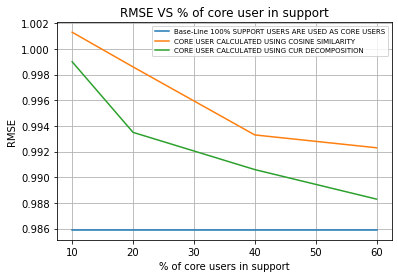

In [62]:
import matplotlib.pyplot as plt

x_axis = [10, 20, 40, 60]
y_axis = [1.0013,0.9986,0.9933, 0.9923]
x1_axis = [10, 20, 40, 60]
y1_axis = [0.9859, 0.9859, 0.9859, 0.9859]
x2_axis = [10, 20, 40, 60]
y2_axis = [0.9990, 0.9935, 0.9906, 0.9883]

plt.plot(x1_axis, y1_axis, label="Base-Line 100% SUPPORT USERS ARE USED AS CORE USERS")
plt.plot(x_axis, y_axis, label="CORE USER CALCULATED USING COSINE SIMILARITY")
plt.plot(x2_axis, y2_axis, label="CORE USER CALCULATED USING CUR DECOMPOSITION")

plt.title('RMSE VS % of core user in support')
plt.xlabel('% of core users in support')
plt.ylabel('RMSE')
plt.grid()
plt.legend(fontsize=7)
plt.show()